# Sentiment Analysis with Transfer Learning and Fine-tuning

This notebook demonstrates how to fine-tune a pre-trained model for a binary sentiment analysis task.

## 1. Setup and Imports

In [1]:
%pip install torch transformers pandas scikit-learn datasets
%pip install --upgrade ipywidgets
%pip install ydata-profiling

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached transformers-4.46.3-py3-none-any.whl.metadata (44 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import time
import psutil
from typing import Dict, List
import warnings
from tqdm import tqdm

from ydata_profiling import ProfileReport
import webbrowser

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification,
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    logging
)


In [3]:

print("=== System Info ===")
print(f"CPU cores: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")
print("\n=== GPU Info ===")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

=== System Info ===
CPU cores: 8
RAM: 31.35 GB

=== GPU Info ===
CUDA available: False


## 2. Data Loading and Preparation

In [4]:
df_sample = pd.read_parquet('../data/sample_reviews.parquet')

print(df_sample.head())
print(df_sample.info())

                                            sentence  label  idx
0  at least one scene is so disgusting that viewe...      0  413
1  even the finest chef ca n't make a hotdog into...      0  701
2  collateral damage finally delivers the goods f...      1  834
3  exciting and direct , with ghost imagery that ...      1  821
4  and when you 're talking about a slapstick com...      0  748
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  150 non-null    object
 1   label     150 non-null    int64 
 2   idx       150 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.1+ KB
None


In [5]:
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

from datasets import load_dataset


Getting the datasets reviews from Hugging Face:

https://huggingface.co/datasets/stanfordnlp/imdb

https://huggingface.co/datasets/SetFit/amazon_reviews_multi_en

In [6]:
data_name = "stanfordnlp/imdb"
# data_name = "SetFit/amazon_reviews_multi_en"

dataset = load_dataset(data_name)

In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [8]:
SAMPLE_SIZE = 300

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

train_samples_per_class = SAMPLE_SIZE // len(train_df['label'].unique())
test_samples_per_class = SAMPLE_SIZE // len(test_df['label'].unique())

train_balanced = pd.concat([
    train_df[train_df['label'] == label].sample(n=train_samples_per_class, random_state=42)
    for label in train_df['label'].unique()
])

test_balanced = pd.concat([
    test_df[test_df['label'] == label].sample(n=test_samples_per_class, random_state=42)
    for label in test_df['label'].unique()
])

name = data_name.split('/')[1]

train_balanced.to_csv(f'../data/{name}_train_balanced.csv', index=False, encoding='utf-8')
test_balanced.to_csv(f'../data/{name}_test_balanced.csv', index=False, encoding='utf-8')

print(f"Balanced train data saved in ./data/{name}_train_balanced.csv: {len(train_balanced)} samples")
print(f"Balanced test data saved in ./data/{name}_test_balanced.csv: {len(test_balanced)} samples")

print("\nClass distribution in Train:")
print(train_balanced['label'].value_counts())
print("\nClass distribution in Test:")
print(test_balanced['label'].value_counts())

Balanced train data saved in ./data/imdb_train_balanced.csv: 300 samples
Balanced test data saved in ./data/imdb_test_balanced.csv: 300 samples

Class distribution in Train:
label
0    150
1    150
Name: count, dtype: int64

Class distribution in Test:
label
0    150
1    150
Name: count, dtype: int64


In [9]:
train_balanced.head()


,text,label
1766,"Wow, what a total let down! The fact people th...",0
11919,"If Bob Ludlum was to see this mini series, he ...",0
8909,To call a film about a crippled ghost taking r...,0
4963,they have sex with melons in Asia.<br /><br />...,0
10099,Although the production and Jerry Jameson's di...,0


In [10]:
train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 1766 to 19219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    300 non-null    object
 1   label   300 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


In [11]:
train_balanced['label'].value_counts()

label
0    150
1    150
Name: count, dtype: int64

Text length statistics per class:
      text_length                                  
       min_length max_length mean_length std_length
label                                              
0             210       4737     1291.05     866.78
1             157       7068     1404.53    1171.32

Overall text length statistics:
         min_length  max_length  mean_length  std_length
Overall         157        7068      1347.79     1030.21


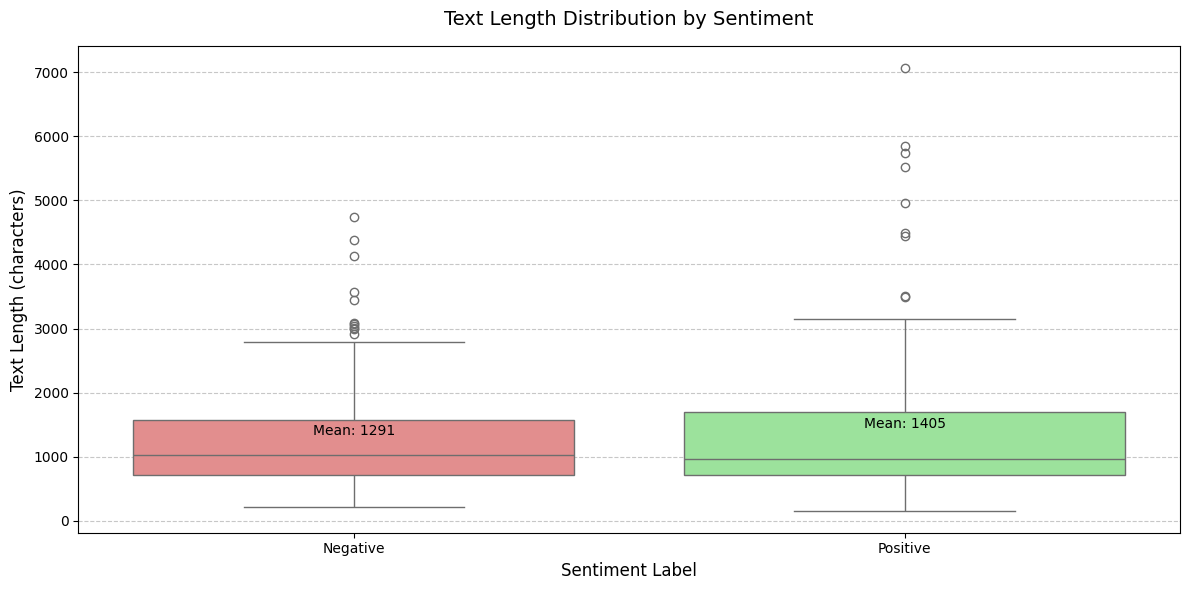

In [12]:
train_balanced['text_length'] = train_balanced['text'].str.len()
length_stats = train_balanced.groupby('label').agg({
    'text_length': [
        ('min_length', 'min'),
        ('max_length', 'max'),
        ('mean_length', 'mean'),
        ('std_length', 'std')
    ]
}).round(2)

overall_stats = pd.DataFrame({
    'min_length': [train_balanced['text_length'].min()],
    'max_length': [train_balanced['text_length'].max()],
    'mean_length': [train_balanced['text_length'].mean()],
    'std_length': [train_balanced['text_length'].std()]
}, index=['Overall']).round(2)

print("Text length statistics per class:")
print(length_stats)
print("\nOverall text length statistics:")
print(overall_stats)

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_balanced, 
            x='label', 
            y='text_length', 
            hue='label',  # Added hue parameter
            palette=['lightcoral', 'lightgreen'],
            legend=False,  # Hide legend since it's redundant
            showfliers=True)

plt.title('Text Length Distribution by Sentiment', fontsize=14, pad=15)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

label_names = {0: 'Negative', 1: 'Positive'}
plt.xticks([0, 1], [label_names[0], label_names[1]])

means = train_balanced.groupby('label')['text_length'].mean()
for i, mean in means.items():
    plt.text(i, mean, f'Mean: {mean:.0f}', 
             horizontalalignment='center',
             verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [13]:
profile = ProfileReport(train_balanced, title="Dataset IMDB")
profile.to_notebook_iframe()  

report_path = f"../reports/ydata_report_{name}.html"
profile.to_file(report_path)
webbrowser.open('file://' + os.path.realpath(report_path))


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

False

## 3. Model and Platform Research and Selection

Models:
- BERT
- RoBERTa
- DistilBERT
- GPT-2
- Electra
- XLNet

**DistilBERT** is good balance between performance and computational efficiency. It is a lighter and faster version of BERT.

Computing platforms:
- AWS Sagemaker Studio Labs
- QBraid
- Google Colab

In [14]:
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

class ModelComparator:
    def __init__(self):
        self.models: Dict = {}
        self.tokenizers: Dict = {}
        self.results: List = []
        
    def load_model(self, model_name: str, verbose: bool = True):
        """Loads a model and its tokenizer."""
        if verbose:
            print(f"Loading {model_name}...", end=' ')
        
        model_configs = {
            'distilbert': ('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel),
            'bert': ('bert-base-uncased', BertTokenizer, BertModel),
            'roberta': ('roberta-base', RobertaTokenizer, RobertaModel),
        }
        
        if model_name in model_configs:
            model_path, TokenizerClass, ModelClass = model_configs[model_name]
            try:
                # Load model and tokenizer
                tokenizer = TokenizerClass.from_pretrained(model_path)
                model = ModelClass.from_pretrained(model_path)
                
                if model_name == 'gpt2':
                    tokenizer.pad_token = tokenizer.eos_token
                    
                self.models[model_name] = model
                self.tokenizers[model_name] = tokenizer
                
                if verbose:
                    print("✓")
                    
            except Exception as e:
                if verbose:
                    print(f"❌ Error: {str(e)}")
                raise
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def measure_performance(self, model_name: str, text: str, num_runs: int = 5, verbose: bool = True):
        """Measures model performance for a given text."""
        if not self.models:
            print("No models loaded. Please load models first.")
            return
            
        if model_name not in self.models:
            print(f"Model {model_name} not found.")
            return
            
        model = self.models[model_name]
        tokenizer = self.tokenizers[model_name]
        
        if verbose:
            print(f"Testing {model_name}...", end=' ')
        
        # Performance measurements
        total_time = 0
        memory_usage = []
        
        # Prepare input
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        
        if model_name == 'xlnet':
            inputs['token_type_ids'] = torch.zeros_like(inputs['input_ids'])
        
        # Multiple runs for averaging
        for _ in range(num_runs):
            start_time = time.time()
            with torch.no_grad():
                outputs = model(**inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            memory_usage.append(psutil.Process().memory_info().rss / 1024 / 1024)
        
        avg_time = total_time / num_runs
        avg_memory = np.mean(memory_usage)
        
        self.results.append({
            'model': model_name,
            'avg_time_ms': round(avg_time * 1000, 2),
            'avg_memory_mb': round(avg_memory, 2),
            'parameters': sum(p.numel() for p in model.parameters()),
            'input_length': len(inputs['input_ids'][0])
        })
        
        if verbose:
            print("✓")
    
    def display_results(self):
        """Shows results in a DataFrame."""
        if not self.results:
            print("No results available. Please run performance tests first.")
            return None
            
        df = pd.DataFrame(self.results)
        
        # Add relative speed comparison (normalized to BERT)
        if 'bert' in df['model'].values:
            bert_time = df[df['model'] == 'bert']['avg_time_ms'].values[0]
            df['relative_speed'] = bert_time / df['avg_time_ms']
            
        return df

def main():
    print("Starting model comparison...")
    
    # Sample texts for analysis
    texts = [
        """This is a longer text that allows us to see how different models behave
        with more extensive content. We want to analyze the differences in processing
        time and memory usage across various transformer architectures."""
    ]
    
    comparator = ModelComparator()
    models = ['distilbert', 'bert', 'roberta']
    
    # Load models
    print("\nLoading models:")
    for model in models:
        try:
            comparator.load_model(model)
        except Exception as e:
            print(f"❌ Skipped {model}: {str(e)}")
    
    # Run tests
    print("\nRunning performance tests:")
    for text in texts:
        print(f"Testing with text of {len(text)} characters")
        for model in comparator.models:
            comparator.measure_performance(model, text)
    
    # Show results
    results = comparator.display_results()
    if results is not None:
        print("\nComparison Results:")
        print(results.to_string(index=False))
    
    return results

if __name__ == "__main__":
    main()

Starting model comparison...

Loading models:
Loading distilbert... ✓
Loading bert... ✓
Loading roberta... ✓

Running performance tests:
Testing with text of 229 characters
Testing distilbert... ✓
Testing bert... ✓
Testing roberta... ✓

Comparison Results:
     model  avg_time_ms  avg_memory_mb  parameters  input_length  relative_speed
distilbert       105.77        1169.06    66362880            40        2.259053
      bert       238.94        1493.29   109482240            40        1.000000
   roberta       277.15        1817.41   124645632            54        0.862132


## 4. Model and Tokenizer Initialization

In [15]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, 
                                 max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

# Set hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3

Using device: cpu


## 5. Data manipulation

In [17]:
# Create datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

NameError: name 'train_texts' is not defined

## 6. Training and Evaluation Functions

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            total_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == batch['labels']).sum().item()
            total += len(batch['labels'])
    
    return total_loss / len(dataloader), correct / total * 100

In [ ]:
best_accuracy = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Training
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    for batch in train_loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == batch['labels']).sum().item()
        total += len(batch['labels'])
        
        train_loop.set_postfix({'loss': loss.item(), 
                              'accuracy': 100 * correct / total})
    
    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, device)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Training Loss: {total_loss/len(train_loader):.4f}')
    print(f'Training Accuracy: {100*correct/total:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'New best model saved with accuracy: {val_accuracy:.2f}%')

## 9. Test the Model


In [ ]:
# Test final model
test_loss, test_accuracy = evaluate_model(model, test_loader, device)
print(f'\nFinal Test Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')

## 10. Save the Model


In [ ]:
model.save_pretrained('./models/sentiment_model')
tokenizer.save_pretrained('./models/sentiment_model')
print("Model saved in './modles/sentiment_model' directory")